<a href="https://colab.research.google.com/github/previoip/py-bachelor-thesis-data-analysis-redo/blob/main/Tensile_Test_Data_fin_post_proc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PLA-CNT Carbon Nanotube Tensile Result
#### auth: Previo Prakasa
#### date: 14/04/2022

---

## Data Preparation

---


In [816]:
DATA_URL = "https://drive.google.com/drive/folders/168WfVGFH2h6WPlfcyntAkz81XY18OTbW?usp=sharing"
DATA_OUTPUT_PATH = "data"
EXPORT_OUTPUT_PATH = "export"
PURGE_LOCAL_DATA = True
SAVE_AND_DOWNLOAD_FIGURES = True

In [817]:
# Missinf deps
!pip install --upgrade xlrd

In [818]:
# Initialize env
import os, shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as prect
import numpy as np
import pandas as pd
import xlrd
from google.colab import files

for z in os.listdir('.'):
  if z[-3:] == 'zip':
    print('removed:', z)
    os.remove(z)

# print(os.listdir('.'))
if PURGE_LOCAL_DATA:
  if os.path.exists(DATA_OUTPUT_PATH):
    print('removed:', DATA_OUTPUT_PATH)
    shutil.rmtree(DATA_OUTPUT_PATH)
  else:
    os.mkdir(DATA_OUTPUT_PATH)

  if os.path.exists(EXPORT_OUTPUT_PATH):
    print('removed:', EXPORT_OUTPUT_PATH)
    shutil.rmtree(EXPORT_OUTPUT_PATH)
  else:
    os.mkdir(EXPORT_OUTPUT_PATH)

if not os.path.exists(DATA_OUTPUT_PATH):
  os.mkdir(DATA_OUTPUT_PATH)

if not os.path.exists(EXPORT_OUTPUT_PATH):
  os.mkdir(EXPORT_OUTPUT_PATH)


removed: results.zip
removed: data
removed: export


In [819]:
# Download tensile dataset if not exist

import gdown

data_list = []

if os.path.exists(DATA_OUTPUT_PATH):
  data_list = sorted([os.path.join(DATA_OUTPUT_PATH, i) for i in os.listdir(DATA_OUTPUT_PATH)])
  print('excel data found on local')
  for d in data_list:
    print('-',d)

if not os.path.exists(DATA_OUTPUT_PATH) or not data_list:
  data_list = gdown.download_folder(url=DATA_URL, output=DATA_OUTPUT_PATH)

excel data found on local


Retrieving folder list


Processing file 1pOvEVOiYKdWkBI6i4OeGmEZjHV9eRQNV PLA Sample 1.xls
Processing file 1RnYXgpQ1CXe18D_QT0NlT4yZgwDxAfyv PLA Sample 2.xls
Processing file 19eScrhk1EuU9lBoER09hdZmQGFVhKGJh PLA Sample 3.xls
Processing file 1eaXMYzDltKmyWNIM4mr7Qq6LWPLbnDHH PLA Sample 4.xls
Processing file 1CG-Rr_ty-mJmThDmSAOAZAT_qiAmhZTa PLA Sample 5.xls
Processing file 1F-nBU-u1qZDPOgXLM6qriHmpb3X7SfkP PLA+CNT Sample 1.xls
Processing file 1Iu0A_ELvIAksP3EhHMvvqezgTl6tE5Uw PLA+CNT Sample 2.xls
Processing file 1gKf12XWIcI-OR1JG8w8eT37Ge9x8gARC PLA+CNT Sample 3.xls
Processing file 1b4kcpZc06uXEd2TQAtjx7vnGNjvYC6IJ PLA+CNT Sample 4.xls
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1pOvEVOiYKdWkBI6i4OeGmEZjHV9eRQNV
To: /content/data/PLA Sample 1.xls
100%|██████████| 44.5k/44.5k [00:00<00:00, 8.97MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RnYXgpQ1CXe18D_QT0NlT4yZgwDxAfyv
To: /content/data/PLA Sample 2.xls
100%|██████████| 44.5k/44.5k [00:00<00:00, 27.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=19eScrhk1EuU9lBoER09hdZmQGFVhKGJh
To: /content/data/PLA Sample 3.xls
100%|██████████| 44.5k/44.5k [00:00<00:00, 43.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eaXMYzDltKmyWNIM4mr7Qq6LWPLbnDHH
To: /content/data/PLA Sample 4.xls
100%|██████████| 44.5k/44.5k [00:00<00:00, 68.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CG-Rr_ty-mJmThDmSAOAZAT_qiAmhZTa
To: /content/data/PLA Sample 5.xls
100%|██████████| 44.5k/44.5k [00:00<00:00, 64.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1F-nBU-u1qZDPOgX

In [820]:
ls

data/  export/  sample_data/  test/


In [821]:
# check data_list 
data_list

['data/PLA Sample 1.xls',
 'data/PLA Sample 2.xls',
 'data/PLA Sample 3.xls',
 'data/PLA Sample 4.xls',
 'data/PLA Sample 5.xls',
 'data/PLA+CNT Sample 1.xls',
 'data/PLA+CNT Sample 2.xls',
 'data/PLA+CNT Sample 3.xls',
 'data/PLA+CNT Sample 4.xls']

---

## Tensile Data Container Class

---


In [822]:
# dataframe wrapper class

class TensileDataFrame:
  def __init__(self, name: str, df: pd.DataFrame, filepath: str, specimen_type: str = ''):
    self.name = name
    self.df = df
    self.filepath = filepath
    self.specimen_type = specimen_type
    self.statistics = {
        'Elongation' : None, 
        'Force' : None, 
        'Et' : None, 
        'Et_calc' : None, 
        'sY' : None, 
        'sY_calc' : None,
        'eY_calc' : None,
        'sM' : None, 
        'eM' : None, 
        'sB' : None, 
        'eB' : None, 
        'h' : None, 
        'b' : None, 
        'A0': None
    }
    self.__st_unit = ['mm', 'N', 'MPa', 'MPa', 'MPa','MPa', '%', 'MPa', '%', 'MPa', '%', 'mm', 'mm', 'mm²']
    self.statistics_unit_ref = dict(zip(self.statistics.keys(), self.__st_unit))

  def append_statistics(self, key, value):
    if key in self.statistics:
      self.statistics[key] = value

  def __repr_stats(self):
    return '\n\t - ' + '\n\t - '.join([f'{a} ({self.statistics_unit_ref[a]})\t: {b}' for a,b in self.statistics.items()])

  def get_summary(self) -> None:
    print(self.__repr__())

  def __repr__(self):
    return f"""
    DF filepath: {self.filepath}
    DF Name: {self.name}
    DF Pre-Calculated Statistics: {self.__repr_stats()}
    DF Head: {self.df.head}\n\n
    """

In [823]:
df_collection = []

# data extraction
for d_file in data_list:

  d_name = d_file.split(os.sep)[-1]
  d_fformat = d_name.split('.')[-1]
  d_name = d_name.split('.')[0]
  d_name = d_name.split(' ')
  d_spec_type = d_name[0]
  d_name = ' '.join(d_name)

  d_data = None
  d_data_temp_statisticsSheet = None

  if d_fformat == 'xls':
    # xls format refer to xlrd 
    d_tempWorkbook =  xlrd.open_workbook(d_file)
    d_tempSheet = d_tempWorkbook.sheet_by_name([i for i in d_tempWorkbook.sheet_names() if i.startswith('Specimen')][0])
    d_data = [d_tempSheet.row_values(r) for r in range(d_tempSheet.nrows)]

    if 'Statistics' in d_tempWorkbook.sheet_names():
      d_tempSheet_Statistics = d_tempWorkbook.sheet_by_name('Statistics')
      d_data_temp_statisticsSheet = [d_tempSheet_Statistics.row_values(r) for r in range(d_tempSheet_Statistics.nrows)]
      d_data_temp_statisticsSheet = np.array([d_data_temp_statisticsSheet[0][1:], d_data_temp_statisticsSheet[2][1:]]).T # Statistics sheet transposed

  elif d_fformat == 'xlsx':
    # xlsx format refer to pd.read_excel 
    # df_read = pd.read_excel(d_file, sheet_name='Sheet1')
    # df_read = pd.read_excel(d_file)
    pass

  if not d_data:
    raise ValueError('No Source Data Found')

  # data cleanup    
  d_data_head = d_data[1]
  d_data_rows = d_data[3:]
  df_temp = pd.DataFrame(d_data_rows, columns=['Strain', 'Stress'])
  df_dataframe = TensileDataFrame(name = d_name, df = df_temp, filepath = d_file, specimen_type=d_spec_type)
  # if d_data_temp_statisticsSheet:
  if 'Statistics' in d_tempWorkbook.sheet_names():
    for metric in d_data_temp_statisticsSheet:
      df_dataframe.append_statistics(metric[0], float(metric[1]))

  df_collection.append(df_dataframe)

In [824]:
print([i.name for i in df_collection])

['PLA Sample 1', 'PLA Sample 2', 'PLA Sample 3', 'PLA Sample 4', 'PLA Sample 5', 'PLA+CNT Sample 1', 'PLA+CNT Sample 2', 'PLA+CNT Sample 3', 'PLA+CNT Sample 4']


In [825]:
# show parsed dataframe summary

import random
df_collection[random.randint(0, len(df_collection)-1)].get_summary()


    DF filepath: data/PLA+CNT Sample 4.xls
    DF Name: PLA+CNT Sample 4
    DF Pre-Calculated Statistics: 
	 - Elongation (mm)	: 2.8306212425231934
	 - Force (N)	: 1039.857421875
	 - Et (MPa)	: 1221.9485914226568
	 - Et_calc (MPa)	: None
	 - sY (MPa)	: 40.12352880319026
	 - sY_calc (MPa)	: None
	 - eY_calc (%)	: None
	 - sM (MPa)	: 40.12352880319026
	 - eM (%)	: 4.3682098388671875
	 - sB (MPa)	: 37.88029769819979
	 - eB (%)	: 5.258609771728516
	 - h (mm)	: 4.14
	 - b (mm)	: 6.26
	 - A0 (mm²)	: 25.916399999999996
    DF Head: <bound method NDFrame.head of       Strain     Stress
0   0.000000   0.280704
1   0.013085   0.420734
2   0.031031   0.619896
3   0.047628   0.822537
4   0.058710   1.048273
..       ...        ...
95  4.648539  39.931011
96  4.764163  39.755982
97  4.895081  39.476106
98  5.049579  39.012040
99  5.258610  37.880298

[100 rows x 2 columns]>


    


---

## Tensile Yield point and Modulus Young re-calculation function from second derivative polyfit

---

Since the dataset obtained from tensile test result shows discrepancy in modulus young obtained from the test apparatus (being tensile yield having same value as ultimate yield), post processing is required to evaluate modulus young value




In [826]:
ls

data/  export/  sample_data/  test/


final yield point eY:3.2627249945319083 sY:32.88597269982408


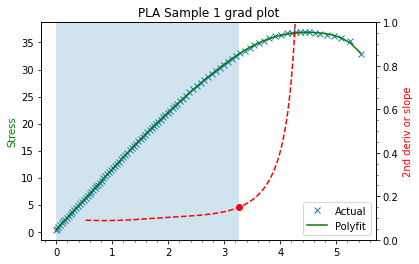

final yield point eY:3.3243834212259813 sY:36.371418157127906


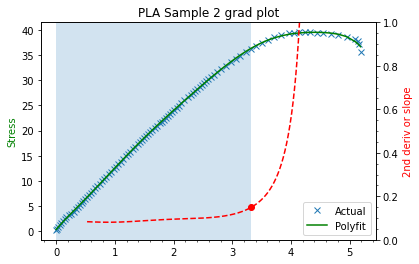

final yield point eY:3.3442401159446122 sY:38.46084521193328


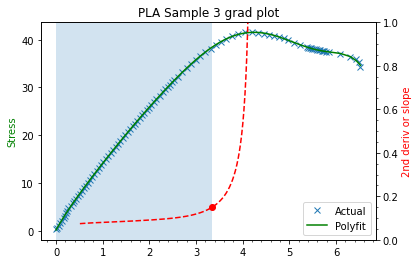

final yield point eY:2.909150911677341 sY:30.80801581779895


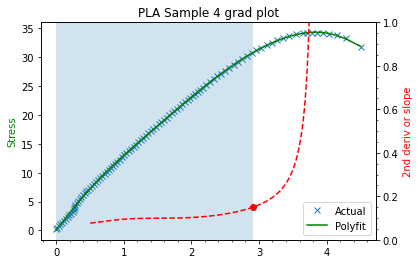

final yield point eY:3.137872280734049 sY:32.9209596202148


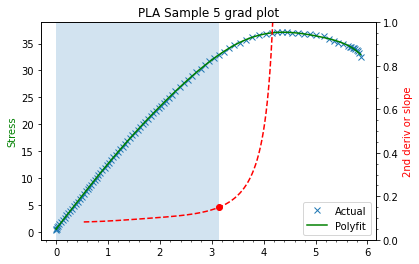

final yield point eY:3.3501308996855523 sY:37.22377418842262


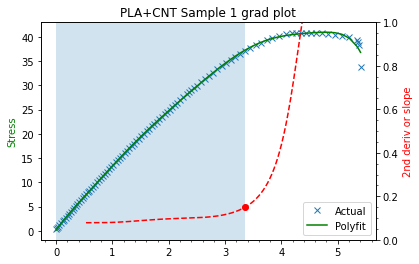

final yield point eY:3.3683409539313836 sY:39.37111962732985


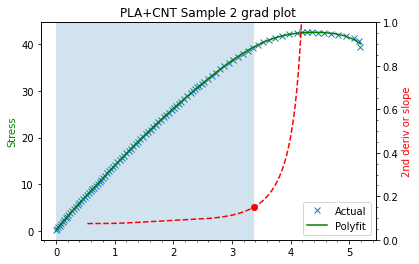

final yield point eY:3.017140238202297 sY:34.27835993190929


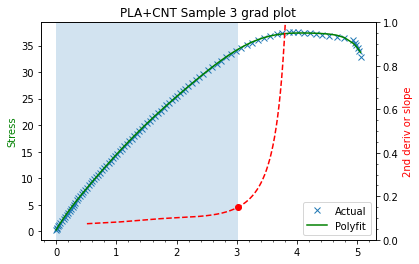

final yield point eY:3.1989668779345726 sY:36.20298703803975


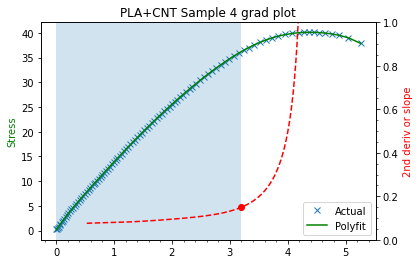

In [827]:
cutoff = .5
threshold = .15
resolution = 1000


subfolder = 'temp_grad_plot_eval'

if not os.path.exists(os.path.join(EXPORT_OUTPUT_PATH, subfolder)):
  os.mkdir(os.path.join(EXPORT_OUTPUT_PATH, subfolder))

for df_item in df_collection:
  
  fig, ax = plt.subplots()
  # plot og df
  plt.title(f"{df_item.name} grad plot")
  figsize = (10,6)

  ax.plot(df_item.df.Strain, df_item.df.Stress, 'x', label="Actual")


  # Createe approx polynomial func from df 
  polyfit_func = np.poly1d(np.polyfit(df_item.df.Strain, df_item.df.Stress, deg=8, full=False))

  # cutoff from df so initial noisy value is not being evaluated 
  d_stress_cutoff = df_item.df.Stress[df_item.df.Strain > cutoff]
  d_strain_cutoff = df_item.df.Strain[df_item.df.Strain > cutoff]

  # get 2nd derivation of function with np.gradient
  x = np.linspace(min(d_strain_cutoff), max(d_strain_cutoff), resolution)  
  y_derivative = np.gradient(x, polyfit_func(x))

  x_trunc = x[y_derivative > 0]
  y_trunc = y_derivative[y_derivative > 0]

  x_trunc = x_trunc[y_trunc < 2]
  y_trunc = y_trunc[y_trunc < 2]

  # plot derivative
  ax.plot(df_item.df.Strain, polyfit_func(df_item.df.Strain), '-', label="Polyfit", color='g')
  ax.set_ylabel('Stress', color='g')
  ax_sub = ax.twinx()
  ax_sub.plot(x_trunc, y_trunc, '-', label="2nd deriv tuncrated",linestyle='--', color='r')
  ax_sub.set_ylim(0,1)
  ax_sub.minorticks_on()

  # filter value until gradient get to rising edge (or graph exits from being linear) 
  y_temp = []
  x_temp = []
  for id in range(len(x)):
    if y_derivative[id] > threshold:
      break
    y_temp.append(y_derivative[id])
    x_temp.append(x[id])
  
  y_derivative = np.array(y_temp)
  x = np.array(x_temp)

  ax.axvspan(0, max(x), alpha=.2)

  # append eY and sY value to df
  eY_calculated = x[x == max(x)]
  sY_calculated = polyfit_func(eY_calculated)
  print(f'final yield point eY:{eY_calculated[0]} sY:{sY_calculated[0]}')
  df_item.append_statistics('sY_calc', sY_calculated[0])
  df_item.append_statistics('eY_calc', eY_calculated[0])
  df_item.append_statistics('Et_calc', sY_calculated[0] * 100 / eY_calculated[0])
  plt.plot(eY_calculated[0], sY_calculated[0], marker='o')
  # plt.plot(eY_calculated[0], sY_calculated[0], label="Youngs Modulus")

  ax_sub.plot(eY_calculated, threshold, marker='o', color='r')
  ax_sub.set_ylabel('2nd deriv or slope', color='r')

  ax.legend(loc='best')
  if SAVE_AND_DOWNLOAD_FIGURES:
    plt.savefig(os.path.join(EXPORT_OUTPUT_PATH, subfolder, f'{df_item.name}'), dpi=200)
  plt.show()


In [828]:
# show again parsed dataframe summary
df_collection[random.randint(0, len(df_collection)-1)].get_summary()


    DF filepath: data/PLA+CNT Sample 1.xls
    DF Name: PLA+CNT Sample 1
    DF Pre-Calculated Statistics: 
	 - Elongation (mm)	: 2.4681997299194336
	 - Force (N)	: 994.6470336914062
	 - Et (MPa)	: 1190.671641511042
	 - Et_calc (MPa)	: 1111.1140221988487
	 - sY (MPa)	: 40.85530994066305
	 - sY_calc (MPa)	: 37.22377418842262
	 - eY_calc (%)	: 3.3501308996855523
	 - sM (MPa)	: 40.85530994066305
	 - eM (%)	: 4.443389892578125
	 - sB (MPa)	: 33.85054952338667
	 - eB (%)	: 5.404710216704763
	 - h (mm)	: 3.84
	 - b (mm)	: 6.34
	 - A0 (mm²)	: 24.345599999999997
    DF Head: <bound method NDFrame.head of       Strain     Stress
0   0.000000   0.307447
1   0.015192   0.511101
2   0.037042   0.817617
3   0.058303   1.164813
4   0.085975   1.556536
..       ...        ...
95  5.205695  39.852081
96  5.337923  39.387919
97  5.360251  38.941389
98  5.382287  38.276992
99  5.404710  33.850550

[100 rows x 2 columns]>


    


---
## Specimen Tensile Data Plot
---


In [829]:
# get color space per specimen type
import colorsys 
def hsv_to_hex(h, s=1, v=1):
  rgb = colorsys.hsv_to_rgb(h,s,v)
  return f'#{int(rgb[0]*255):0>2X}{int(rgb[1]*255):0>2X}{int(rgb[2]*255):0>2X}'

color_temp = []
for i in df_collection:
  if i.specimen_type not in color_temp:
    color_temp.append(i.specimen_type)

color_dict = {}
for i, x in enumerate(color_temp):
  color_dict[x] = hsv_to_hex((i/len(color_temp) * 0.8), v=.7)
del color_temp

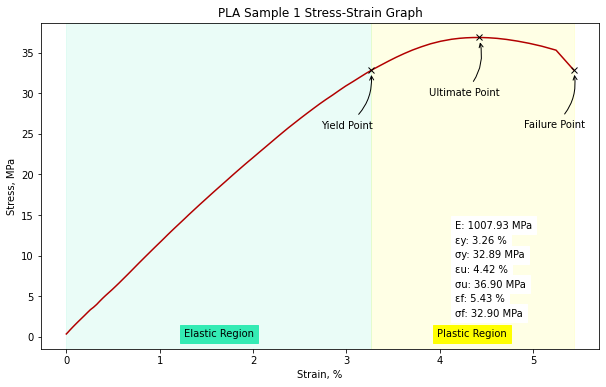

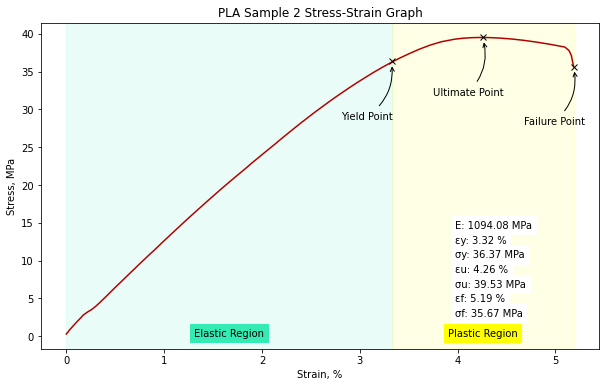

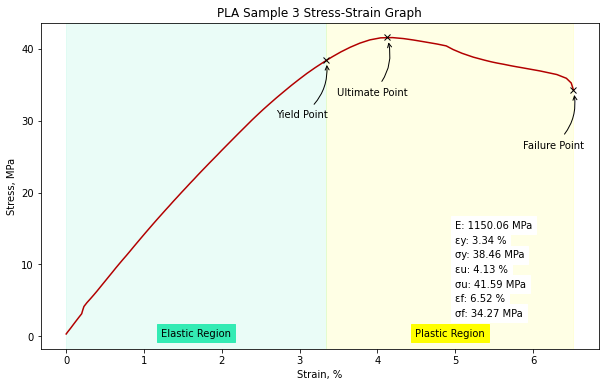

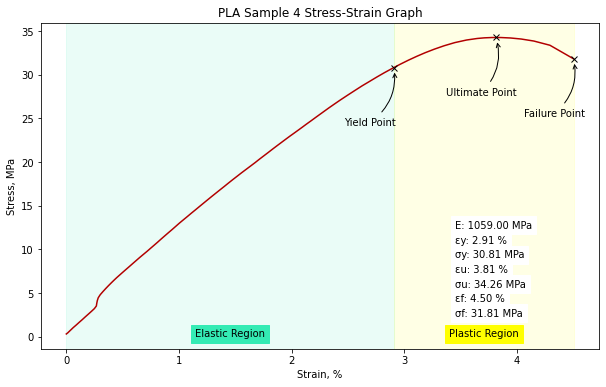

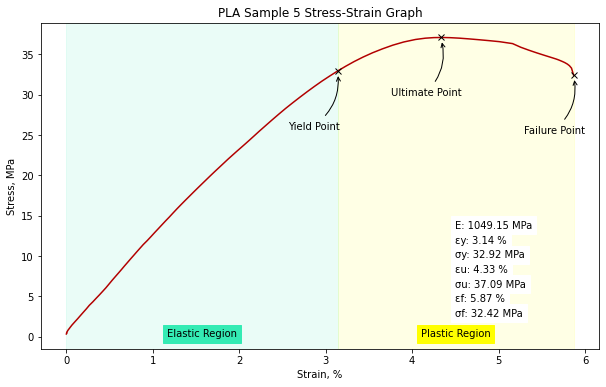

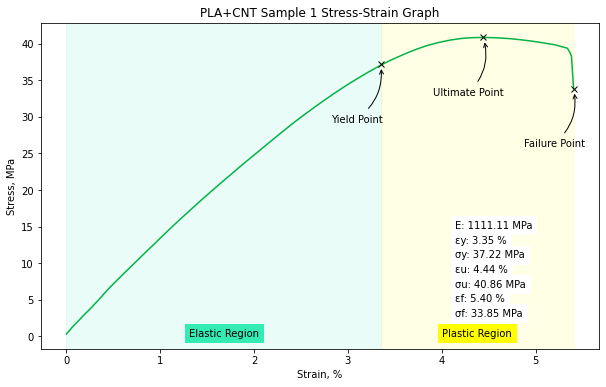

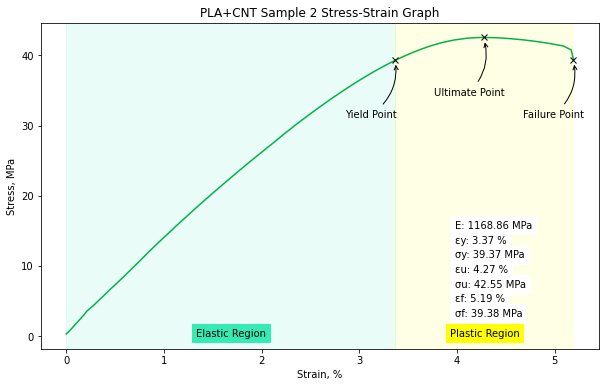

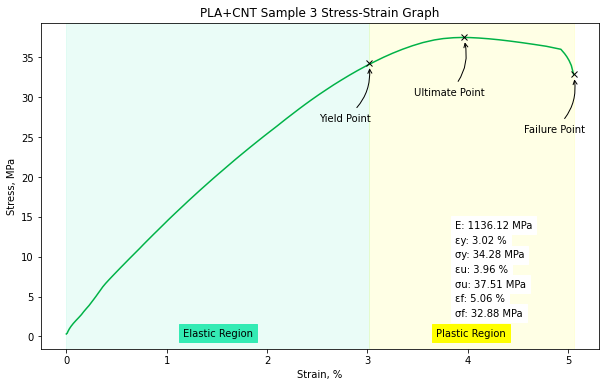

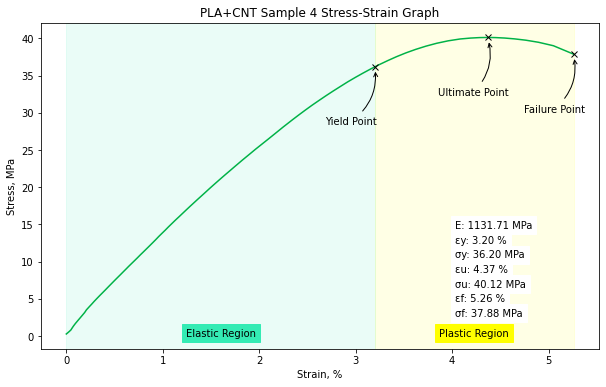

In [830]:
figsize=(10,6)

subfolder = 'tensile_graph'

if not os.path.exists(os.path.join(EXPORT_OUTPUT_PATH, subfolder)):
  os.mkdir(os.path.join(EXPORT_OUTPUT_PATH, subfolder))

for i_df in df_collection:
  fig, ax = plt.subplots()
  # ax.spines['left'].set_position('zero')
  # ax.spines['bottom'].set_position('zero')

  i_df.df.plot(
      ax=ax,
      x='Strain',
      xlabel='Strain, %', 
      ylabel='Stress, MPa', 
      title= f'{i_df.name} Stress-Strain Graph', 
      figsize=figsize,
      color=color_dict[i_df.specimen_type],
      legend=False
      )
  
  eval_metric = {
      'Ultimate Point': (i_df.statistics['eM'], i_df.statistics['sM']),
      # 'Yield Point': ((i_df.statistics['sY'] * 100 / i_df.statistics['Et']), i_df.statistics['sY']); Discrepancy in Data, where tensile-yield == tensile-ultimate
      'Yield Point': (i_df.statistics['eY_calc'], i_df.statistics['sY_calc']),
      'Failure Point': (i_df.statistics['eB'], i_df.statistics['sB']),
  }

  for k, v in eval_metric.items():
    plt.plot([v[0]], [v[1]], marker='x', c='black')
    # ax.annotate(f'{k}\nstrain {v[0]:.2f} \nstress {v[1]:.2f}', 
    ax.annotate(f'{k}', 
                [v[0], v[1]],
                xytext=(-50,-50), 
                textcoords='offset points',
                arrowprops=dict(
                    facecolor='black', 
                    arrowstyle="->",
                    shrinkA=5, 
                    shrinkB=5,
                    connectionstyle="arc3,rad=0.3"
                    ), 
                horizontalalignment='left', 
                verticalalignment='top'
                )
    

  eval_region = {
      'Elastic Region': (0, i_df.statistics['eY_calc'], '#34ebb4'),
      'Plastic Region': (i_df.statistics['eY_calc'], i_df.statistics['eB'], 'yellow'),
  }
  for k, v in eval_region.items():
    ax.axvspan(v[0], v[1], 
               alpha=.1,
               color=v[2],
               )
    
    plt.annotate(k, 
              xy=(v[0], 1),  
              xycoords='data',
              xytext=((v[0]+v[1])/2,0),
              textcoords='data',
              horizontalalignment='center', 
              backgroundcolor = v[2],
              )
  # plt.plot([0, i_df.statistics['eY_calc']], [0, i_df.statistics['sY_calc']], marker='')


  # plt.plot([0, (i_df.statistics['sY'] * 100 / i_df.statistics['Et'])], [0, i_df.statistics['sY']], marker='')
  # ax.annotate(f'Modulus Young\n {i_df.name}', 
  #             [(i_df.statistics['sY'] * 100 / i_df.statistics['Et']), i_df.statistics['sY']],
  #             xytext=(-35,-40), 
  #             textcoords='offset points', 
  #             )
  
  stats_to_show = {
      'sB': 'σf', 
      'eB': 'εf', 
      'sM': 'σu', 
      'eM': 'εu', 
      'sY_calc': 'σy', 
      'eY_calc': 'εy',
      'Et_calc': 'E', 
      }
  for n, stat in enumerate(stats_to_show):
    text = i_df.statistics[stat]
    plt.figtext(.7, .2 + (.034*n), f'{stats_to_show[stat]}: {text:.2f} {i_df.statistics_unit_ref[stat]}', backgroundcolor='white')
  if SAVE_AND_DOWNLOAD_FIGURES:
    plt.savefig(os.path.join(EXPORT_OUTPUT_PATH, subfolder, f'{i_df.name}_graph.png'), dpi=300)
  plt.show()  
  

---

## Plotting all tensile strength graphs as bar chart

---

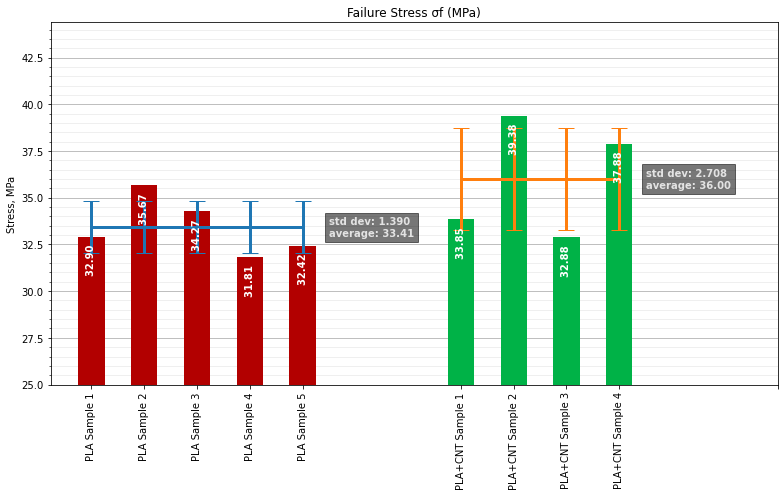

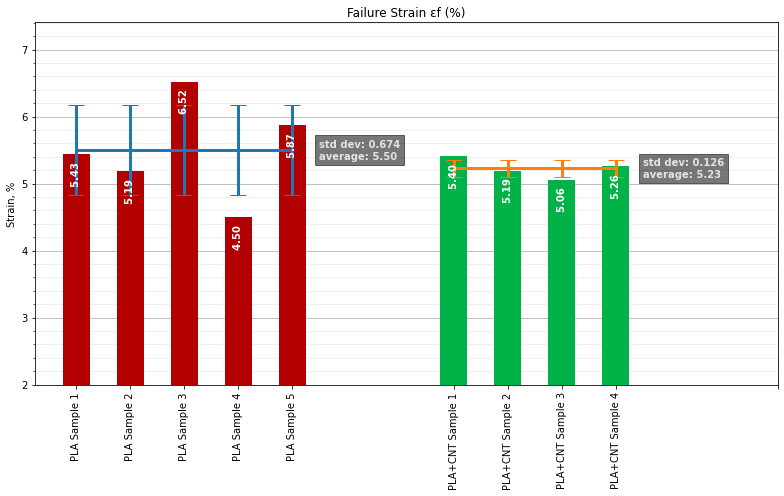

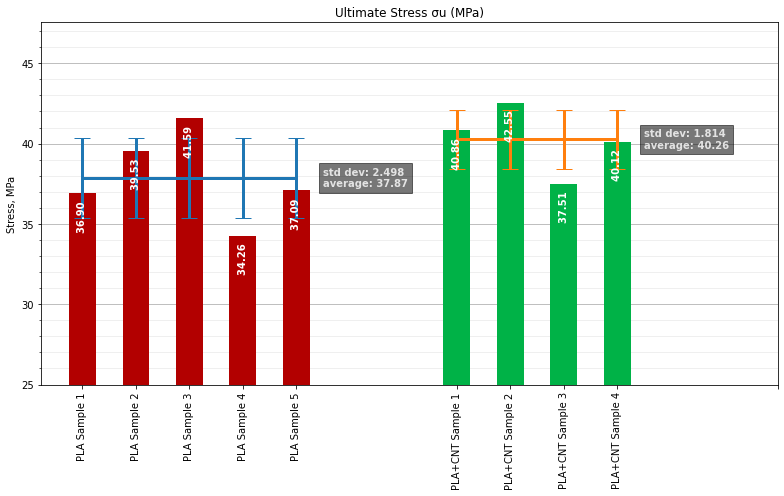

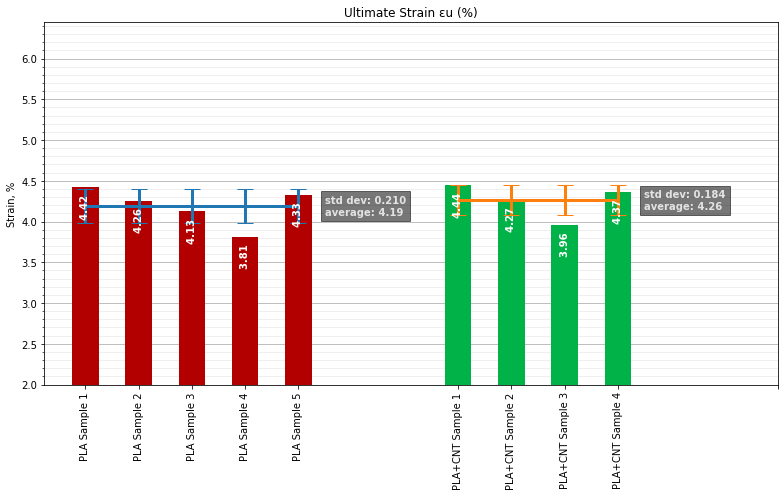

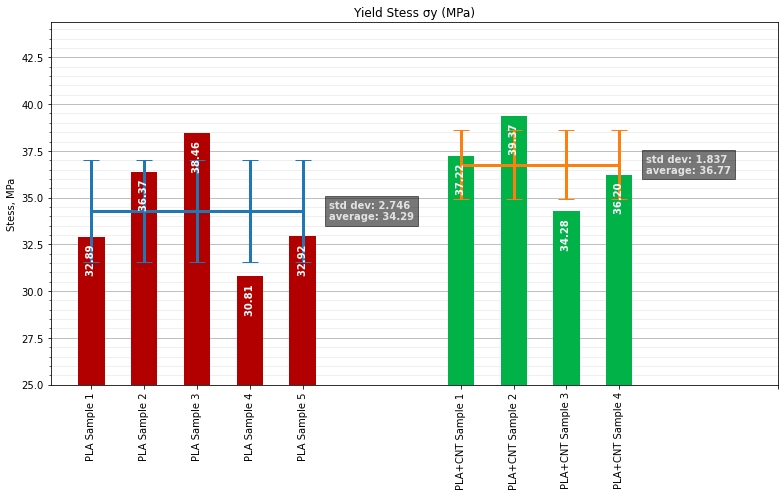

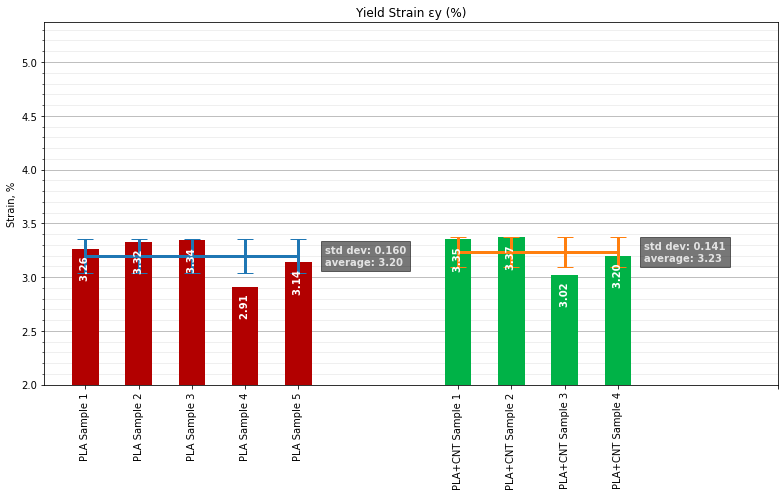

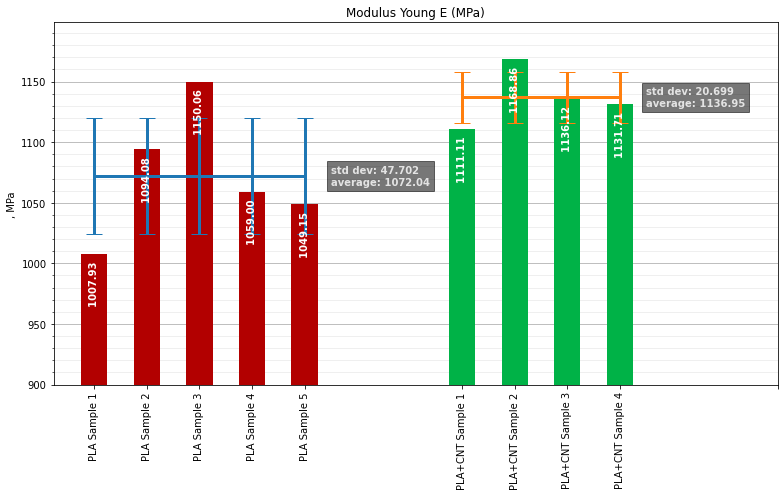

In [831]:
figsize=(11,7)

subfolder = 'bar_chart'

if not os.path.exists(os.path.join(EXPORT_OUTPUT_PATH, subfolder)):
  os.mkdir(os.path.join(EXPORT_OUTPUT_PATH, subfolder))

stats_to_show = {
    'sB': 'Failure Stress σf', 
    'eB': 'Failure Strain εf', 
    'sM': 'Ultimate Stress σu', 
    'eM': 'Ultimate Strain εu', 
    'sY_calc': 'Yield Stess σy', 
    'eY_calc': 'Yield Strain εy',
    'Et_calc': 'Modulus Young E', 
    }

y_axis_dict = {
    'sB': 'Stress', 
    'eB': 'Strain', 
    'sM': 'Stress', 
    'eM': 'Strain', 
    'sY_calc': 'Stess', 
    'eY_calc': 'Strain',
    'Et_calc': '', 
    }

for cat in stats_to_show:
  temp_values = {}
  # get df types
  for i_df in df_collection:
    if i_df.specimen_type not in temp_values:
      temp_values[i_df.specimen_type] = {'key':[], 'val':[]}
    temp_values[i_df.specimen_type]['key'].append(i_df.name)
    temp_values[i_df.specimen_type]['val'].append(i_df.statistics[cat])

  fig, ax = plt.subplots(figsize=figsize)
  ax.set_axisbelow(True)
  ax.set_ylabel(f'{y_axis_dict[cat]}, {i_df.statistics_unit_ref[cat]}')
  ax.set_title(f'{stats_to_show[cat]} ({i_df.statistics_unit_ref[cat]})')
    
  offset_list = []
  key_list = []
  width = .4
  last_offset = 0
  padding = .2
  total_len = 0

  for i in temp_values:
    for j in temp_values[i]['key']:
      total_len += width

  for s_type in temp_values:


    key = np.array(temp_values[s_type]['key'])
    val = np.array(temp_values[s_type]['val'])
    std_dev = np.std(val)
    val_avg = np.average(val)

    ylim = (2,max(val) + 2)
    if cat.startswith('s'):
      ylim = (25,max(val) + 5)
    elif cat.startswith('E'):
      ylim = (900,max(val) + 30)
    ax.set_ylim(ylim)


    offset = [(width*i) + last_offset for i in range(len(temp_values[s_type]['key']))]
    last_offset = max(offset) + width + padding * 4
    offset_list += offset
    key_list += temp_values[s_type]['key']
    plt.bar(offset, temp_values[s_type]['val'], width = width - padding, color=color_dict[s_type])
    
    # xmin = min(offset)/total_len
    # xmax = max(offset)/total_len
    # ax.axhline(val_avg, xmin=xmin, xmax = xmax)

    for id, of in enumerate(offset):
      plt.text(of, val[id], f'{val[id]:.2f}  ', rotation=90, color='white', verticalalignment='top', horizontalalignment='center', fontweight='heavy')
    plt.text(max(offset)+padding, val_avg, f'std dev: {std_dev:.3f}\naverage: {val_avg:.2f}', verticalalignment='center', backgroundcolor='#00000088', color='white', alpha=.8, fontweight='heavy')

    plt.errorbar(offset, [val_avg for i in range(len(offset))], yerr=[std_dev for i in range(len(offset))], capsize=8, linewidth = 3)
    plt.xticks(offset_list, key_list, rotation=90, in_layout=True)


  ax.set_xticks(list(ax.get_xticks()) + [max(list(ax.get_xticks()))+1.2])
  plt.grid(axis='y', which='major', zorder=0)
  plt.grid(axis='y', which='minor', zorder=0, color='#ebebeb')
  ax.xaxis.set_tick_params(which='minor', bottom=False)
  plt.minorticks_on()
  fig.tight_layout()
  if SAVE_AND_DOWNLOAD_FIGURES:
    plt.savefig(os.path.join(EXPORT_OUTPUT_PATH, subfolder, f'{subfolder}_{cat}'))
  plt.show()
    

---
## Download graphs
---

In [832]:
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

if os.path.exists(EXPORT_OUTPUT_PATH):
  list_files(EXPORT_OUTPUT_PATH)

export/
    temp_grad_plot_eval/
        PLA+CNT Sample 1.png
        PLA+CNT Sample 2.png
        PLA Sample 3.png
        PLA Sample 4.png
        PLA Sample 2.png
        PLA+CNT Sample 4.png
        PLA+CNT Sample 3.png
        PLA Sample 5.png
        PLA Sample 1.png
    bar_chart/
        bar_chart_sY_calc.png
        bar_chart_eB.png
        bar_chart_eM.png
        bar_chart_sB.png
        bar_chart_sM.png
        bar_chart_Et_calc.png
        bar_chart_eY_calc.png
    tensile_graph/
        PLA Sample 2_graph.png
        PLA Sample 4_graph.png
        PLA+CNT Sample 2_graph.png
        PLA Sample 3_graph.png
        PLA Sample 5_graph.png
        PLA+CNT Sample 3_graph.png
        PLA+CNT Sample 4_graph.png
        PLA Sample 1_graph.png
        PLA+CNT Sample 1_graph.png


In [833]:
!zip -r /content/results.zip /content/export

  adding: content/export/ (stored 0%)
  adding: content/export/temp_grad_plot_eval/ (stored 0%)
  adding: content/export/temp_grad_plot_eval/PLA+CNT Sample 1.png (deflated 6%)
  adding: content/export/temp_grad_plot_eval/PLA+CNT Sample 2.png (deflated 6%)
  adding: content/export/temp_grad_plot_eval/PLA Sample 3.png (deflated 6%)
  adding: content/export/temp_grad_plot_eval/PLA Sample 4.png (deflated 6%)
  adding: content/export/temp_grad_plot_eval/PLA Sample 2.png (deflated 6%)
  adding: content/export/temp_grad_plot_eval/PLA+CNT Sample 4.png (deflated 6%)
  adding: content/export/temp_grad_plot_eval/PLA+CNT Sample 3.png (deflated 6%)
  adding: content/export/temp_grad_plot_eval/PLA Sample 5.png (deflated 6%)
  adding: content/export/temp_grad_plot_eval/PLA Sample 1.png (deflated 6%)
  adding: content/export/bar_chart/ (stored 0%)
  adding: content/export/bar_chart/bar_chart_sY_calc.png (deflated 12%)
  adding: content/export/bar_chart/bar_chart_eB.png (deflated 14%)
  adding: content

In [834]:
if SAVE_AND_DOWNLOAD_FIGURES:
  files.download("/content/results.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>